### 1. Import modules

In [72]:
#importing libraries
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
import warnings
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
import requests
from bs4 import BeautifulSoup as bs

In [2]:
#importing new libraries
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

### 2. Parsing the HTML
Using data from: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [4]:
from urllib.request import urlopen
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = urlopen(url).read().decode('utf-8')
soup = BeautifulSoup(page, 'html.parser')

wiki_table = soup.body.table.tbody

### 3. Extract data from table to data frame

In [5]:
def get_cell(element):
    cells = element.find_all('td')
    row = []
    
    for cell in cells:
        if cell.a:            
            if (cell.a.text):
                row.append(cell.a.text)
                continue
        row.append(cell.string.strip())
        
    return row

In [6]:
def get_row():    
    data = []  
    
    for tr in wiki_table.find_all('tr'):
        row = get_cell(tr)
        if len(row) != 3:
            continue
        data.append(row)        
    
    return data

In [7]:
data = get_row()
columns = ['Postcode', 'Borough', 'Neighbourhood']
df = pd.DataFrame(data, columns=columns)
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### 4. Clean data

In [8]:
#ignore cells with no assigned borough
df1 = df[df.Borough != 'Not assigned']
df1 = df1.sort_values(by=['Postcode','Borough'])

df1.reset_index(inplace=True)
df1.drop('index',axis=1,inplace=True)

df1.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [18]:
df_postcodes = df1['Postcode']
df_postcodes.drop_duplicates(inplace=True)
df2 = pd.DataFrame(df_postcodes)
df2['Borough'] = '';
df2['Neighbourhood'] = '';


df2.reset_index(inplace=True)
df2.drop('index', axis=1, inplace=True)
df1.reset_index(inplace=True)
df1.drop('index', axis=1, inplace=True)

#if more than one neighborhood
for i in df2.index:
    for j in df1.index:
        if df2.iloc[i, 0] == df1.iloc[j, 0]:
            df2.iloc[i, 1] = df1.iloc[j, 1]
            df2.iloc[i, 2] = df2.iloc[i, 2] + ',' + df1.iloc[j, 2]
            
for i in df2.index:
    s = df2.iloc[i, 2]
    if s[0] == ',':
        s =s [1:]
    df2.iloc[i,2 ] = s

In [47]:
df2.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [43]:
!pip install geocoder
!pip install folium

import geocoder

In [44]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords

[43.70909000000006, -79.36409999999995]

In [49]:
# Retrieving Postal Code Co-ordinates
postcode = df2['Postcode']    
coords = [ get_latilong(postcode) for postcode in postcode.tolist() ]

In [51]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df2['Latitude'] = df_coords['Latitude']
df2['Longitude'] = df_coords['Longitude']
df2.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81153,-79.19552
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78564,-79.15871
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17520
3,M1G,Scarborough,Woburn,43.76820,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76969,-79.23944


In [115]:
#create new df for downtown toronto
df_dt = df2.copy()
df_dt = df_dt[df2.Borough.str.contains("Downtown Toronto")]
df_dt

,Postcode,Borough,Neighbourhood,Latitude,Longitude
50,M4W,Downtown Toronto,Rosedale,43.68190,-79.37850
51,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.66788,-79.36649
52,M4Y,Downtown Toronto,Church and Wellesley,43.66659,-79.38130
53,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65514,-79.36265
54,M5B,Downtown Toronto,"Garden District, Ryerson",43.65736,-79.37818
55,M5C,Downtown Toronto,St. James Town,43.65143,-79.37557
56,M5E,Downtown Toronto,Berczy Park,43.64531,-79.37368
57,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493
58,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.64970,-79.38258
59,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.64285,-79.38040


### 5. Map of Downtown Toronto

In [55]:
CLIENT_ID = 'ALBUZU4P4YSINSSQTSG2CH4VYFRELVFL0ZSFKYICCJ0BZ5BG'
CLIENT_SECRET = 'DYP2YJDFWZUBDSHQRTTBFQ3HADGYPWFRIAGTL3AZZ2N3OTAI'
VERSION = '20180604'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: ALBUZU4P4YSINSSQTSG2CH4VYFRELVFL0ZSFKYICCJ0BZ5BG
CLIENT_SECRET: DYP2YJDFWZUBDSHQRTTBFQ3HADGYPWFRIAGTL3AZZ2N3OTAI


In [69]:
toronto_map = folium.Map(location = [43.65, -79.4], zoom_start = 12)

for latitude, longitude, borough, neighbourhood in zip(df_dt['Latitude'], df_dt['Longitude'], df_dt['Borough'], df_dt['Neighbourhood']):
    label = folium.Popup(borough, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color= '#3186cc',
        fill_opacity=0.7).add_to(toronto_map)  

toronto_map

In [89]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
   longitude, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [88]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [86]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 6. Categorize Nearby Venues / Locations

In [90]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Queen's Park,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",43.663946,-79.392180
1,Philosopher's Walk,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",43.666894,-79.395597
2,Koerner Hall,"[{'id': '5032792091d4c4b30a586d5c', 'name': 'C...",43.667983,-79.395962
3,Royal Ontario Museum,"[{'id': '4bf58dd8d48988d181941735', 'name': 'M...",43.668367,-79.394813
4,Hart House Theatre,"[{'id': '4bf58dd8d48988d137941735', 'name': 'T...",43.663571,-79.394616


In [91]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Queen's Park,Park,43.663946,-79.392180
1,Philosopher's Walk,Park,43.666894,-79.395597
2,Koerner Hall,Concert Hall,43.667983,-79.395962
3,Royal Ontario Museum,Museum,43.668367,-79.394813
4,Hart House Theatre,Theater,43.663571,-79.394616


In [92]:
#check top 5 categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:5]

Coffee Shop           8
Café                  7
Italian Restaurant    5
Clothing Store        5
Restaurant            5
Name: categories, dtype: int64

In [93]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [95]:
DT_venues = getNearbyVenues(names=df_dt['Neighbourhood'],
                                   latitudes=df_dt['Latitude'],
                                   longitudes=df_dt['Longitude']
                                  )

Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government


In [96]:
print('There are {} Uniques Categories.'.format(len(DT_venues['Venue Category'].unique())))
DT_venues.groupby('Neighborhood').count().head()

There are 219 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,100,100,100,100,100,100
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",95,95,95,95,95,95
Central Bay Street,100,100,100,100,100,100
Christie,66,66,66,66,66,66
Church and Wellesley,100,100,100,100,100,100


### Using One Hot Encoding

In [97]:
# one hot encoding
DT_onehot = pd.get_dummies(DT_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
DT_onehot['Neighborhood'] = DT_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [DT_onehot.columns[-1]] + list(DT_onehot.columns[:-1])
DT_onehot = DT_onehot[fixed_columns]
DT_grouped = DT_onehot.groupby('Neighborhood').mean().reset_index()
DT_onehot.head(5)

,Yoga Studio,Afghan Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Health & Beauty Service,Historic Site,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Ramen Restaurant,Record Shop,Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rosedale,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [100]:
num_top_venues = 5
for hood in DT_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =DT_grouped[DT_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Berczy Park ----
                 venue  freq
0          Coffee Shop  0.09
1           Restaurant  0.05
2                Hotel  0.05
3                 Café  0.05
4  Japanese Restaurant  0.04


---- CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport ----
                venue  freq
0                 Gym  0.09
1         Coffee Shop  0.09
2                Café  0.05
3                Park  0.04
4  Italian Restaurant  0.04


---- Central Bay Street ----
            venue  freq
0     Coffee Shop  0.12
1  Clothing Store  0.06
2            Café  0.03
3     Art Gallery  0.03
4           Plaza  0.03


---- Christie ----
               venue  freq
0  Korean Restaurant  0.18
1      Grocery Store  0.11
2               Park  0.05
3              Diner  0.05
4               Café  0.05


---- Church and Wellesley ----
                 venue  freq
0          Coffee Shop  0.10
1  Japanese Restaurant  0.05
2                Diner  0.03
3         

In [101]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common venues in Downtown Toronto

In [133]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = DT_grouped['Neighborhood']

for ind in np.arange(DT_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(DT_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Restaurant,Café,Hotel,Beer Bar,Japanese Restaurant,Italian Restaurant,Bakery,Cheese Shop,Seafood Restaurant
1,"CN Tower, King and Spadina, Railway Lands, Har...",Gym,Coffee Shop,Café,Italian Restaurant,Park,Sandwich Place,Restaurant,Japanese Restaurant,Caribbean Restaurant,Spa
2,Central Bay Street,Coffee Shop,Clothing Store,Café,Art Gallery,Plaza,Italian Restaurant,Diner,Hotel,Electronics Store,Japanese Restaurant
3,Christie,Korean Restaurant,Grocery Store,Café,Coffee Shop,Park,Diner,Mexican Restaurant,Pizza Place,Indian Restaurant,Karaoke Bar
4,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Café,Diner,Thai Restaurant,Bubble Tea Shop,Smoke Shop
5,"Commerce Court, Victoria Hotel",Coffee Shop,Café,Seafood Restaurant,Restaurant,American Restaurant,Hotel,Concert Hall,Japanese Restaurant,Beer Bar,Vegetarian / Vegan Restaurant
6,"First Canadian Place, Underground city",Hotel,Coffee Shop,Café,Restaurant,Seafood Restaurant,Asian Restaurant,American Restaurant,Concert Hall,Gym,Japanese Restaurant
7,"Garden District, Ryerson",Coffee Shop,Clothing Store,Cosmetics Shop,Bubble Tea Shop,Italian Restaurant,Japanese Restaurant,Burger Joint,Theater,Gastropub,Pizza Place
8,"Harbourfront East, Union Station, Toronto Islands",Coffee Shop,Café,Hotel,Brewery,Restaurant,Japanese Restaurant,Concert Hall,Park,Scenic Lookout,Sandwich Place
9,"Kensington Market, Chinatown, Grange Park",Café,Vegetarian / Vegan Restaurant,Coffee Shop,Bar,Pizza Place,Arts & Crafts Store,Yoga Studio,Dessert Shop,Mexican Restaurant,Gaming Cafe


### K-Means Clustering Approach

In [130]:
# Cluster neighborhood into 3 clusters
DT_grouped_clustering = DT_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(DT_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1],
      dtype=int32)

In [131]:
neighborhoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)

DT_merged =df_dt.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
DT_merged = DT_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

DT_merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,M4W,Downtown Toronto,Rosedale,43.68190,-79.37850,2,Park,Candy Store,Playground,Grocery Store,Women's Store,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
51,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.66788,-79.36649,1,Coffee Shop,Restaurant,Park,Café,Pizza Place,Chinese Restaurant,Gastropub,Diner,Pub,Bakery
52,M4Y,Downtown Toronto,Church and Wellesley,43.66659,-79.38130,1,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Ramen Restaurant,Café,Diner,Thai Restaurant,Bubble Tea Shop,Smoke Shop
53,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65514,-79.36265,1,Coffee Shop,Theater,Park,Café,Restaurant,Pub,Bakery,Performing Arts Venue,Breakfast Spot,Thai Restaurant
54,M5B,Downtown Toronto,"Garden District, Ryerson",43.65736,-79.37818,1,Coffee Shop,Clothing Store,Cosmetics Shop,Bubble Tea Shop,Italian Restaurant,Japanese Restaurant,Burger Joint,Theater,Gastropub,Pizza Place
55,M5C,Downtown Toronto,St. James Town,43.65143,-79.37557,1,Coffee Shop,Café,Restaurant,Seafood Restaurant,Clothing Store,Japanese Restaurant,Bakery,American Restaurant,Hotel,Italian Restaurant
56,M5E,Downtown Toronto,Berczy Park,43.64531,-79.37368,1,Coffee Shop,Restaurant,Café,Hotel,Beer Bar,Japanese Restaurant,Italian Restaurant,Bakery,Cheese Shop,Seafood Restaurant
57,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493,1,Coffee Shop,Clothing Store,Café,Art Gallery,Plaza,Italian Restaurant,Diner,Hotel,Electronics Store,Japanese Restaurant
58,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.64970,-79.38258,1,Hotel,Coffee Shop,Café,Restaurant,Theater,Japanese Restaurant,Fast Food Restaurant,Bakery,Beer Bar,Italian Restaurant
59,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.64285,-79.38040,1,Coffee Shop,Café,Hotel,Brewery,Restaurant,Japanese Restaurant,Concert Hall,Park,Scenic Lookout,Sandwich Place


### Create map of clusters

In [132]:
kclusters = 2

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(DT_merged['Latitude'], 
                                   DT_merged['Longitude'], 
                                   DT_merged['Neighbourhood'], 
                                   DT_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


['#8000ff', '#ff0000']


In [134]:
dfone=DT_merged.loc[DT_merged['Cluster Labels'] == 0,DT_merged.columns[[2] + list(range(5, DT_merged.shape[1]))]]
dftwo=DT_merged.loc[DT_merged['Cluster Labels'] == 1,DT_merged.columns[[2] + list(range(5, DT_merged.shape[1]))]]
dfthree=DT_merged.loc[DT_merged['Cluster Labels'] == 2,DT_merged.columns[[2] + list(range(5, DT_merged.shape[1]))]]

In [141]:
DT_Avg_RentPrice=pd.DataFrame({"Neighborhood":df_dt["Neighbourhood"],
                                      "Average_Rent_Price":[573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0, 425000.0]})

In [142]:
DT_Avg_RentPrice.set_index('Neighborhood',inplace=True,drop=True)

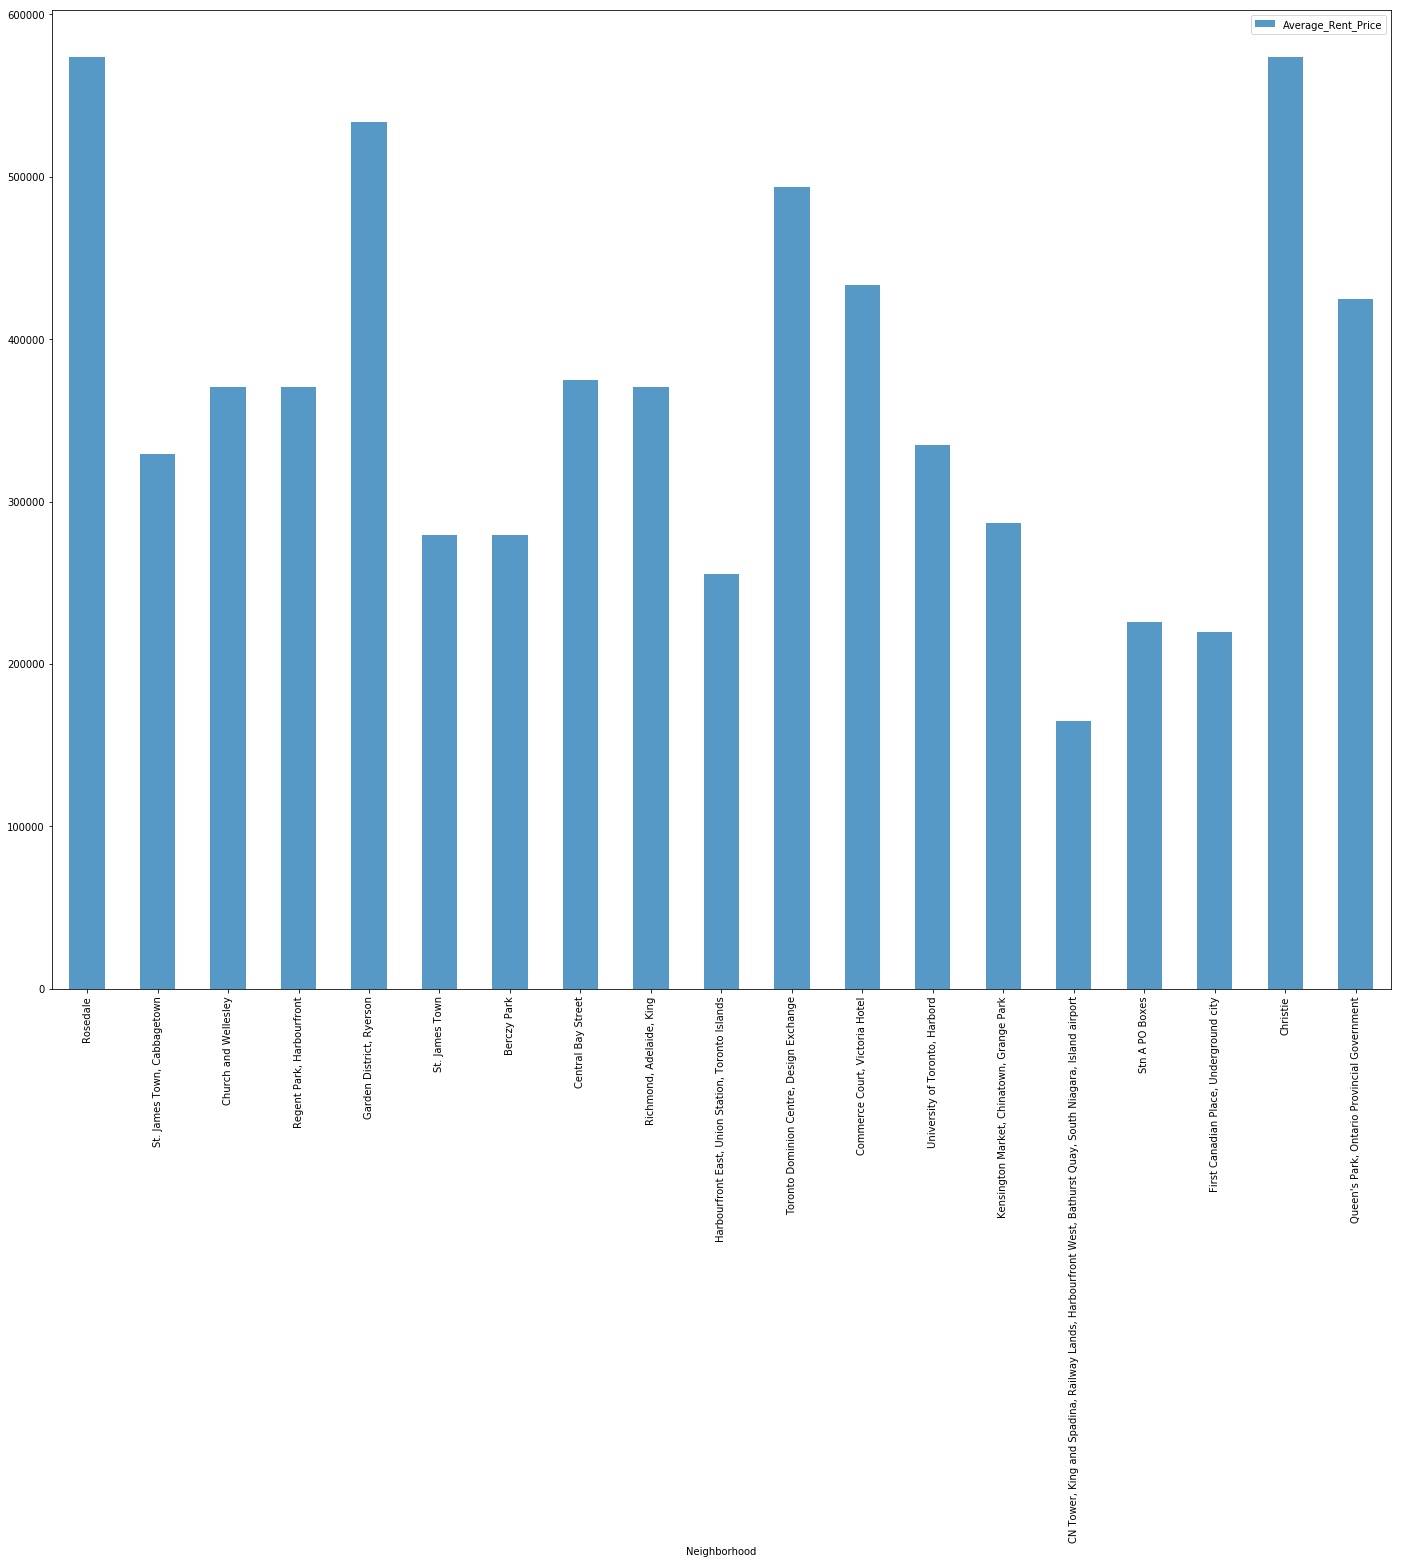

In [143]:
DT_Avg_RentPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)
